### Time series forecasting:
- Regelbundna tidsserier kan predikteras
- Jag skriver min egna kod från boken. Raphaels CodeAlong finns i skolans repo.
#### Prediktera framtida temperatur baserat på historisk mätdata:
- Kapitel 10 i Deep Learning with Python
- Förutom forecasting, så kan time series användas för tex classification (bot or human), event detection (tex hot word detection like "hey google") eller anomali detection (unusual activity)
- fourier transform kan användas för att pre processa data.
- RNN's är en förutsättning för att lyckas med tidsserie analys, eftersom ...
- 



Read in data:

In [1]:
import os
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt



In [2]:
fname = os.path.abspath('data\\jena_climate_2009_2016.csv\\jena_climate_2009_2016.csv')

with open (fname) as f:
    data = f.read()

lines = data.split('\n') # split the data into lines
header = lines[0].split(',') # split the header into columns
lines = lines[1:] # remove the header from the data

print(f'len(lines): {len(lines)}')
print(f'len(header): {len(header)}')
print(f'Datatype Data: {type(data)}')
print(f'Datatype Lines: {type(lines)}')
print(f'Datatype Header: {type(header)}')
print(f'Header: {header}')


len(lines): 420451
len(header): 15
Datatype Data: <class 'str'>
Datatype Lines: <class 'list'>
Datatype Header: <class 'list'>
Header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [3]:
lines[0:2]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10']

Ändra data typen från string till Numpy arrayer:

In [4]:
temperature = np.zeros((len(lines),)) # create an array of zeros to store the temperature data
raw_data = np.zeros((len(lines), len(header) - 1)) # create an array of zeros to store the raw data

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # convert the values to floats
    temperature[i] = values[1] # store the temperature
    raw_data[i, :] = values # store the raw data


In [5]:
temperature[0:5]

array([-8.02, -8.41, -8.51, -8.31, -8.27])

In [6]:
raw_data[0:5]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02],
       [ 9.96510e+02, -8.31000e+00,  2.65120e+02, -9.07000e+00,
         9.42000e+01,  3.26000e+00,  3.07000e+00,  1.90000e-01,
         1.92000e+00,  3.08000e+00,  1.30919e+03,  3.40000e-01,
         5.00000e-01,  1.98000e+02],
       [ 9.96510e+02, -8.27000e+00,  2.65150e+02, -9.04000e+00,
         9.41000e+01

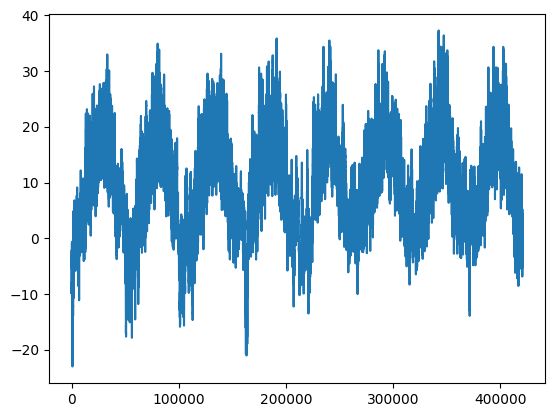

In [7]:
plt.plot(range(len(temperature)), temperature)

Plottar temperaturen de 10 första dygnen:

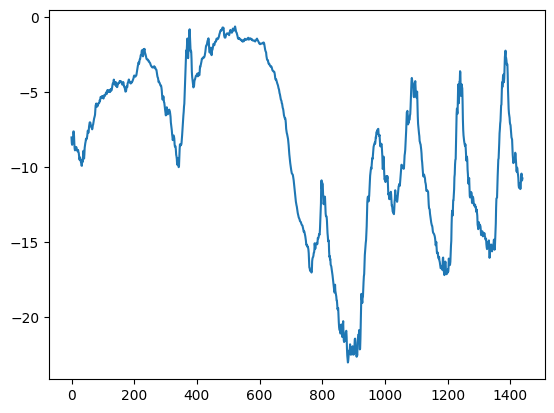

In [8]:
plt.plot(range(1440), temperature[:1440])

#### Train | Val | Test - split:

In [9]:
num_train_samples = int(0.5*len(lines))
num_val_samples = int(0.25*len(lines)) 
num_test_samples = len(lines) - num_train_samples - num_val_samples

num_train_samples, num_val_samples, num_test_samples

(210225, 105112, 105114)

#### Normalisering:
- Datan måste också normaliseras:
- Endast träningsdatan normaliseras i detta fallet. CoPilot: att endast normalisera träningsdatan gör att man undviker data leakage.
- Normaliseringen vi gör motsvarar det som kallar StandardScaler i SkLearn, dvs man subtraherar medelvärdet från alla observationer och sedan delar man med standardavvikelsen.


In [10]:
mean = raw_data[:num_train_samples].mean(axis=0) # calculate the mean of the training data
raw_data -= mean # subtract the mean from the data
std = raw_data[:num_train_samples].std(axis=0) # calculate the standard deviation of the training data
raw_data /= std # divide the data by the standard deviation

#### Skapar train | val | test datasets
- anvnder Keras inbyggda funktion "timeseries_dataset_from_array" för att skapa dataseten
- varje dataset ger en tuple (samples, targets), där samples är en batch av 256 samples, där varje sample innehåller 120 consecutiva timmar och targets är en array av 256 target temperaturer.
- datan är shufflad, så tex samples[0] och samples[1] är inte nödvändigtvis nära varandra.

In [11]:
sampling_rate = 6 # one data point per hour
sequence_length = 120 # 5 days (5*24 hours)
delay = sampling_rate * (sequence_length + 24 -1) # one day
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,# shuffle the data
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=None)


#### Inspekterar outputen från att vi skapade dataseten

In [12]:
for samples, targets in train_dataset:
    print(samples.shape, targets.shape)
    break   

(256, 120, 14) (256,)


#### Common sense baseline:
- Innan man applicerar en mer avancerad teknik är en "common sense baseline" bra att ta fram. Den kommer ge en metric som man ska försöka slå med mer avancerade machine learning modeller.
- I detta fallet antas att temperaturen om 24 timmar är samma som den nuvarnde temperaturen.
- Val av metric är MAE, som definieras:  
`np.mean(np.abs(preds - targets))`


In [13]:
# definierar en funktion som evaluerar en naive metod:
def evaluate_naive_method(dataset):
    total_abs_error = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1] # the temperature at the last time step
        total_abs_error += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_error / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


#### Basic Machine Learning model:
- Man ska börja med en enklare modell för att ha något att jämföra med när man ökar komplexiteten.
- Ett vanligt neuralt nätverk fungerar oftast dåigt på tidsserier. Bland annat för att Flatten eller Reshape lagret plattat ut tidsserien vilket förstör tidsserien (kolla förklaringen i boken sidan 292.)
- I boken provar man ett CNN också, men då förstör MaxPooling lagret vilket också förstör information ("order information" enligt boken)
- RNN's är rätt beräkningsmässigt krävande.


Undersöker på vilket format tensorerna är:

In [19]:
print(f"Sequence length: {sequence_length}")
print(f"Raw data shape: {raw_data.shape}")
print(f"Raw data shape: {raw_data.shape[-1]}")

for batch in train_dataset.take(1):
    print(f"Train batch input shape: {batch[0].shape}")  # Should be (batch_size, 120, 14)
    print(f"Train batch label shape: {batch[1].shape}")



Sequence length: 120
Raw data shape: (420451, 14)
Raw data shape: 14
Train batch input shape: (256, 120, 14)
Train batch label shape: (256,)


- Definierar ett neuralt nätverk med 16 noder och en output (för regression)
- Callbacks för att spara de bäst presterand modellen
- Kompilerar modellen
- tränar modellen
- läser in den sparade modellen (som är den bäst presterande)
- gör model.evaluate och plottar MAE för bäst presterande modellen

In [16]:
import keras

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) # define the input layer
#x = layers.Flatten()(inputs) # (DENNA ANVÄNDS I BOKEN MEN FUNKAR INTE!)flatten the input
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs) # (DENNA FUNKAR!) reshape the input
x = layers.Dense(16, activation='relu')(x) # define the hidden layer
outputs = layers.Dense(1)(x) # define the output layer
model = keras.Model(inputs, outputs) # create the model

callbacks = [keras.callbacks.ModelCheckpoint('jena_dense_baseline.keras', save_best_only=True)] # define the checkpoint
model.compile(optimizer='rmsprop', loss='mse', metrics=["mae"]) # compile the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks) # train the model

model = keras.models.load_model('jena_dense_baseline.keras') # load the best model
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # evaluate the model


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - loss: 17.0301 - mae: 3.1329 - val_loss: 11.2605 - val_mae: 2.6432
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 9.0724 - mae: 2.3686 - val_loss: 15.1938 - val_mae: 3.0905
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 8.2603 - mae: 2.2605 - val_loss: 12.3250 - val_mae: 2.7849
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 7.7444 - mae: 2.1911 - val_loss: 10.4388 - val_mae: 2.5601
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 7.3736 - mae: 2.1408 - val_loss: 10.5023 - val_mae: 2.5666
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 7.1338 - mae: 2.1064 - val_loss: 10.7746 - val_mae: 2.6006
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 6.9244 - mae: 2.0739 - val_loss: 10.5067 - val_mae: 2.5577
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 6.7837 - mae: 2.0518 - val_loss: 10.5305 - val_mae: 2.5627
Epoch 9/10
819/819 ━━━━━━━━━━━━

In [17]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

Utvärderar modellena utveckling över tid:

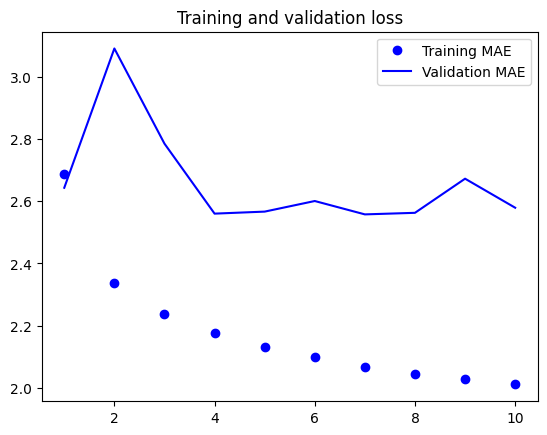

In [18]:
loss = history.history['mae'] # extract the loss
val_loss = history.history['val_mae'] # extract the validation loss
epochs = range(1, len(loss) + 1) # create a range of the number of epochs
plt.figure() # create a new figure
plt.plot(epochs, loss, 'bo', label='Training MAE') # plot the training loss
plt.plot(epochs, val_loss, 'b', label='Validation MAE') # plot the validation loss
plt.title('Training and validation loss') # set the title
plt.legend() # show the legend
plt.show() # show the plot

#### Recurrent Neural Network (RNN)
- RNN's är utvecklade för tidsserier, de förstör inte "sekvens information".
- LSTM är en form av RNN
#### LSTM
- Nedan är "bästa" LSTM modellen från boken:
- Denna modellen når aldrig overfit. Det innebär att finns potential i att förbättra modellen. Man ska öka kapaciteten i modellen tills man når overfit (vi gör det senare med GRU)
- Nedan modell har både Dropout Layer och recurrent_dropout. Utan dropout hade detta nätverket overfitat direkt.
- Nätverk med dropout tar alltid längre tid att konvergera, därför epochs=50


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) # define the input layer
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) # define the LSTM layer
x = layers.Dropout(0.5)(x) # define the dropout layer
outputs = layers.Dense(1)(x) # define the output layer

model = keras.Model(inputs, outputs) # create the model

callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras', save_best_only=True)] # define the checkpoint

model.compile(optimizer='rmsprop', loss='mse', metrics=["mae"]) # compile the model

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks) # train the model

model = keras.models.load_model('jena_lstm_dropout.keras') # load the best model
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # evaluate the model

### Stacking recurrent networks, GRU
- 

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) # define the input layer
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs) # define the GRU layer
x = layers.GRU(32, recurrent_dropout=0.5)(x) # define the GRU layer
outputs = layers.Dense(1)(x) # define the output layer

model = keras.Model(inputs, outputs) # create the model

callbacks = [keras.callbacks.ModelCheckpoint('jena_gru_dropout.keras', save_best_only=True)] # define the checkpoint

model.compile(optimizer='rmsprop', loss='mse', metrics=["mae"]) # compile the model

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks) # train the model

model = keras.models.load_model('jena_gru_dropout.keras') # load the best model
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") # evaluate the model

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 222s 264ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 212s 259ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 212s 259ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 207s 253ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 212s 258ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
334/819 ━━━━━━━━━━━━━━━━━━━━ 1:55 238ms/step - loss: nan - mae: nan

KeyboardInterrupt: 

Baselina modell för att ge en grund att jämföra med.
Kan tex var nuvarande temperatur fast 24 timmar in i framtiden.
MAE är användbar här (Mean Absolute Error)
Raphael evaluerar den naiva metoden
`samples[:, -1, 1]` Raphael berättar vad den gör, men det handlar om dimensionerna på arrayen
